# TPC based Cosmic Rate measurement
This notebook does only use the event/pfp trees

## Imports

In [1]:
import uproot
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import helpfunction as helper
%matplotlib inline

In [2]:
pd.options.display.max_columns=999

## Constants

In [3]:
main_tree_name = 'cosmicstudies'

# Input files
file_name_mc_sce = './input/corsika_p_sce_30k.root'
file_name_mc_ddsce = './input/corsika_p_ddsce_8k.root'
file_name_mc_nosce = './input/corsika_p_nosce_6k.root'
file_name_mc_cmc = './input/corsika_cmc_sce_8k.root'

file_name_data1 = './input/extunbiased_run1_temp.root'
file_name_data3 = './input/CosmicStudiesCRT_run3_48k_mcc9.root'

outdir = './Output/Paper/'

good_start = -0.4e6          # Start of MC time where we are not biased by out of time charge
good_end = 0.4e6             # End of good MC time window (in ns)
t_begin = good_start/1e6
t_end = good_end/1e6

per1 = 50-45#68.27/2            # 1sigma stat boundaries
per2 = 50+45#68.27/2
per21 = 50-95.45/2
per22 = 50+95.45/2

ub_tag = "MicroBooNE, In Progress"

In [4]:
mc_keys       = ['sce', 'ddsce', 'nosce', 'cmc']
mc_file_names = [file_name_mc_sce, file_name_mc_ddsce, file_name_mc_nosce, file_name_mc_cmc]
mc_files      = [uproot.open(f)[main_tree_name] for f in mc_file_names]
mc_labs       = ['CORSIKA, simulated space charge    ',
                 'CORSIKA, data-driven space charge  ',
                 'CORSIKA, without space charge      ',
                 'CORSIKA+CMC, simulated space charge']

data_file     = uproot.open(file_name_data1)[main_tree_name]
data_lab      = 'Cosmic Data (Run 1)'

## Functions

In [5]:
def cosmic_angles(mom_x, mom_y, mom_z,df_out=True):
    mask_flip_dir = (mom_y>0)*2-1
    mom_x, mom_y, mom_z = mask_flip_dir*mom_x,mask_flip_dir*mom_y,mask_flip_dir*mom_z
    
    theta_cosmic = np.arctan2(np.sqrt(np.square(mom_x)+np.square(mom_z)),mom_y)
    phi_cosmic = np.arctan2(mom_x,mom_z)
    if df_out:
        return pd.DataFrame({'zenith':theta_cosmic, 'azimuth':phi_cosmic})[['zenith','azimuth']]
    else:
        return np.array([theta_cosmic, phi_cosmic])

In [6]:
def straight_length(x_s, y_s, z_s, x_e, y_e, z_e):
    return np.sqrt((x_s-x_e)**2 + (y_s-y_e)**2 + (z_s-z_e)**2)

In [7]:
def cosmic_angles_start_end(x_s, y_s, z_s, x_e, y_e, z_e, df_out=True):
    return cosmic_angles(x_s-x_e, y_s-y_e, z_s-z_e, df_out)

In [8]:
# should return resolution per bin
def getResolution(data_x, data_y, x_edges, ax, periodic=False):
    mean = []
    err = []
    mids = 0.5*(x_edges[1:] + x_edges[:-1])
    bin_id = np.digitize(data_x, x_edges)
    data_diff = data_y-data_x
    if periodic:
        data_diff = (data_diff+np.pi) % (2*np.pi) - np.pi
        data_diff*=(180/np.pi)
        mids*=(180/np.pi)
    for i in range(1,len(x_edges)):
        ax.hist(data_diff[bin_id==i], bins=50, range =np.percentile(data_diff, [per21,per22]), histtype='step')
        percentiles = np.percentile(data_diff[bin_id==i], [per1,50,per2])
        print(round(mids[i-1]),"\t", np.median(data_y[bin_id==i]), "\t", percentiles, "\t", (percentiles[-1]-percentiles[0])/2)
        if periodic:
            percentiles/=(180/np.pi)
            mean.append(mids[i-1]/(180/np.pi)+percentiles[1])
        else:
            mean.append(mids[i-1]+percentiles[1])
        err.append([percentiles[1]-percentiles[0], percentiles[2]-percentiles[1]])
    if periodic:
        mids/=(180/np.pi)
    return mids,mean,err

## Queries

In [9]:
clean_query =  "(pfp_length_traj>25)"
matched_muon_query = "(track_matched_pdgcode==13 | track_matched_pdgcode==-13)"

## Load the data

Event numbers and scales

In [10]:
data_n    = data_file['Event'].numentries
print("%s \tEvents: %d\n"% (data_lab, data_n))

mc_n      = []
mc_scales = []

for l,f in zip(mc_labs, mc_files):
    mc_n.append(f['Event'].numentries)
    mc_scales.append(data_n/mc_n[-1])
    print("%s \tEvents: %d \tScale: {0:0.2f}".format(mc_scales[-1]) % (l, mc_n[-1]))

Cosmic Data (Run 1) 	Events: 22405

CORSIKA, simulated space charge     	Events: 29800 	Scale: 0.75
CORSIKA, data-driven space charge   	Events: 7880 	Scale: 2.84
CORSIKA, without space charge       	Events: 6200 	Scale: 3.61
CORSIKA+CMC, simulated space charge 	Events: 8160 	Scale: 2.75


In [11]:
# Load pfp df
mc_pfp = [f['PFParticles'].pandas.df() for f in mc_files]
data_pfp = data_file[b'PFParticles'].pandas.df()

In [12]:
# Add the reco zenith/azimuth angles fro reco particles based on the trajectory
for df in mc_pfp+[data_pfp]:
    cols = ['track_startx', 'track_starty', 'track_startz', 'track_endx', 'track_endy', 'track_endz']
    df[['pfp_zenith_traj','pfp_azimuth_traj']] = cosmic_angles_start_end(*df[cols].T.values)
    df['pfp_length_traj'] = straight_length(*df[cols].T.values)

# Add the reco zenith/azimuth angles for tuth particles based on the trajectory
for df in mc_pfp:
    cols = ['track_matched_startx_sce', 'track_matched_starty_sce', 'track_matched_startz_sce', 
            'track_matched_endx_sce', 'track_matched_endy_sce', 'track_matched_endz_sce']
    df[['mc_zenith_traj','mc_azimuth_traj']] = cosmic_angles_start_end(*df[cols].T.values)

In [13]:
mc_pfp[0].keys()

Index(['event', 'run', 'subrun', 'num_pfp', 'num_mcp', 'num_mcp_saved',
       'num_flashes', 'pdg_code', 'num_daughters', 'is_primary', 'n_hits',
       'n_clusters', 'pfp_vx', 'pfp_vy', 'pfp_vz', 'track_valid',
       'track_startx', 'track_starty', 'track_startz', 'track_endx',
       'track_endy', 'track_endz', 'track_length', 'track_hasmomentum',
       'track_startmomentumx', 'track_startmomentumy', 'track_startmomentumz',
       'track_endmomentumx', 'track_endmomentumy', 'track_endmomentumz',
       'track_theta', 'track_phi', 'track_zenith', 'track_azimuth',
       'track_mcs_momentum', 'track_mcs_mom_err', 'track_mcs_likelihood',
       'track_mcs_energy', 'track_matched_pdgcode', 'track_matched_energy',
       'track_matched_kBeamNeutrino', 'track_matched_time',
       'track_matched_process', 'track_matched_end_process',
       'track_matched_startinside', 'track_matched_endinside',
       'track_matched_partinside', 'track_matched_startx',
       'track_matched_starty', 't

In [14]:
# Create a bool representing the one-to-one 25+cm muon tracks:
# for resolutions, we use the p_sce frame
mc_pfp[0]['unique'] = ~mc_pfp[0].query(clean_query).query(matched_muon_query).duplicated(subset=['track_matched_time', 'track_matched_energy'], keep=False)
print("One-to-one muon matched:\t{0:0.2f}%".format(sum(mc_pfp[0]['unique']==True)/len(mc_pfp[0].query(clean_query))*100))
print("Broken muon matched:    \t{0:0.2f}%".format(sum(mc_pfp[0]['unique']==False)/len(mc_pfp[0].query(clean_query))*100))
print("Matched to another type:\t{0:0.2f}%".format(mc_pfp[0].query(clean_query)['unique'].isna().sum()/len(mc_pfp[0].query(clean_query))*100))

mc_pfp[0]['time_drift_ok'] = mc_pfp[0]['track_matched_time'].between(good_start,good_end)
df_resolution = mc_pfp[0].query('time_drift_ok & unique')

One-to-one muon matched:	97.71%
Broken muon matched:    	1.32%
Matched to another type:	0.97%


## Plots

In [15]:
mc_def = 1 #ddsce
mc_lab = 'CORSIKA'
mc_scale = mc_scales[mc_def]

Data: 104.95+-0.22
MC: 84.78+-0.33
Data/MC: 1.238+-0.006

Data: 18.92+-0.04
MC: 18.07+-0.06
Data/MC: 1.0468+-0.0040

Data: 15.30+-0.03
MC: 15.09+-0.05
Data/MC: 1.0144+-0.0037


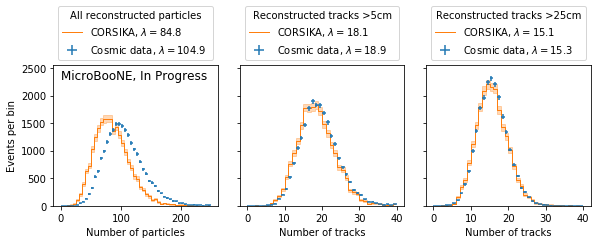

In [16]:
fig, ax = plt.subplots(ncols = 3, sharey=True, figsize=(8.5,3.5))

field = 'num_pfp'
N=50
x_min = 0
x_max = 250
data = [mc_files[mc_def]['Event'].array(field), 
        data_file['Event'].array(field)]
weights = [mc_scale, 1]
edges, edges_mid, bins, err, max_y = helper.histHelper(N, x_min, x_max, data, weights=weights)
means = ([x.mean() for x in data])
means_err = [x.std()/np.sqrt(len(x)) for x in data]
ax[0].step(edges_mid, bins[0], lw=1, label=mc_lab+r', $\lambda=${0:.1f}'.format(means[0]), where='mid', color='C1')
ax[0].fill_between(edges_mid, bins[0] - err[0], bins[0] + err[0], alpha=0.3, step='mid', color='C1')
ax[0].errorbar(edges_mid, bins[1], yerr=err[1], xerr=edges[:-1]-edges_mid, fmt='none', c='C0', 
               zorder=3, label="Cosmic data"+r', $\lambda=${0:.1f}'.format(means[1]))
ax[0].legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title='All reconstructed particles', loc='lower center', mode='expand')
ax[0].set_xlabel("Number of particles")
ax[0].set_ylabel("Events per bin")
ax[0].set_ylim(0, max(max_y)*1.1)
print('Data: {0:0.2f}+-{1:0.2f}'.format(means[1], means_err[1]))
print('MC: {0:0.2f}+-{1:0.2f}'.format(means[0], means_err[0]))
ratio = means[1]/means[0]
r_err = np.sqrt((means_err[0]/means[0])**2 + (means_err[1]/means[1])**2)*ratio
print('Data/MC: {0:.3f}+-{1:0.3f}'.format(ratio,r_err))

field = 'num_pfp_saved'
N=40
x_min = 0
x_max = 40
data = [mc_files[mc_def]['Event'].array(field), 
        data_file['Event'].array(field)]
weights = [mc_scale, 1]
edges, edges_mid, bins, err, max_y = helper.histHelper(N, x_min, x_max, data, weights=weights)
means = ([x.mean() for x in data])
means_err = [x.std()/np.sqrt(len(x)) for x in data]
ax[1].step(edges_mid, bins[0], lw=1, label=mc_lab+r', $\lambda=${0:.1f}'.format(means[0]), where='mid', color='C1')
ax[1].fill_between(edges_mid, bins[0] - err[0], bins[0] + err[0], alpha=0.3, step='mid', color='C1')
ax[1].errorbar(edges_mid, bins[1], yerr=err[1], xerr=edges[:-1]-edges_mid, fmt='none', c='C0', 
               zorder=3, label="Cosmic data"+r', $\lambda=${0:.1f}'.format(means[1]))
ax[1].legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title='Reconstructed tracks >5cm', loc='lower center', mode='expand')
ax[1].set_xlabel("Number of tracks")
ax[1].set_ylim(0, max(max_y)*1.1)
print('\nData: {0:0.2f}+-{1:0.2f}'.format(means[1], means_err[1]))
print('MC: {0:0.2f}+-{1:0.2f}'.format(means[0], means_err[0]))
ratio_5cm = means[1]/means[0]
r_err = np.sqrt((means_err[0]/means[0])**2 + (means_err[1]/means[1])**2)*ratio_5cm
print('Data/MC: {0:.4f}+-{1:0.4f}'.format(ratio_5cm,r_err))


data = [mc_pfp[mc_def].query(clean_query).groupby(['run', 'subrun', 'event', 'num_mcp']).size(),
        data_pfp.query(clean_query).groupby(['run', 'subrun', 'event']).size()]
weights = [mc_scale, 1]
edges, edges_mid, bins, err, max_y = helper.histHelper(N, x_min, x_max, data, weights=weights)
means = ([x.mean() for x in data])
means_err = [x.std()/np.sqrt(len(x)) for x in data]
ax[2].step(edges_mid, bins[0], lw=1, label=mc_lab+r', $\lambda=${0:.1f}'.format(means[0]), where='mid', color='C1')
ax[2].fill_between(edges_mid, bins[0] - err[0], bins[0] + err[0], alpha=0.3, step='mid', color='C1')
ax[2].errorbar(edges_mid, bins[1], yerr=err[1], xerr=edges[:-1]-edges_mid, fmt='none', c='C0', 
               zorder=3, label="Cosmic data"+r', $\lambda=${0:.1f}'.format(means[1]))
ax[2].legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title='Reconstructed tracks >25cm', loc='lower center', mode='expand')
ax[2].set_xlabel("Number of tracks")
ax[2].set_ylim(0, max(max_y)*1.1)
print('\nData: {0:0.2f}+-{1:0.2f}'.format(means[1], means_err[1]))
print('MC: {0:0.2f}+-{1:0.2f}'.format(means[0], means_err[0]))
ratio_25cm = means[1]/means[0]
r_err = np.sqrt((means_err[0]/means[0])**2 + (means_err[1]/means[1])**2)*ratio_25cm
print('Data/MC: {0:.4f}+-{1:0.4f}'.format(ratio_25cm,r_err))

ax[0].text(0, ax[0].get_ylim()[1]*0.9, ub_tag, size=12)
fig.tight_layout()
plt.savefig(outdir+"num_pfp.pdf", bbox_inches="tight")

In [17]:
#mc_keys= ['sce', 'ddsce', 'nosce', 'cmc']
mc_alpha = [0.8, 0.8, 0, 0]
mc_color = ['C2', 'C1', 'C3', 'C4']

track_zenith = {
    "name": 'pfp_zenith_traj',
    "bins": 50,
    "x_min": 0,
    "x_max": np.pi/2,
    "x_label": r"Zenith angle of reconstructed track [rad]",
    "x_ticks": [0,np.pi/8,np.pi/4,3*np.pi/8,np.pi/2],
    "x_labels": [r'$0$',r'$\pi/8$',r'$\pi/4$',r'$3\pi/8$',r'$\pi$/2']
}

track_azimuth = {
    "name": 'pfp_azimuth_traj',
    "bins": 50,
    "x_min": -np.pi,
    "x_max": np.pi,
    "x_label": r"Azimuthal angle of reconstructed track [rad]",
    "x_ticks": [-np.pi,-3*np.pi/4,-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2,3*np.pi/4,np.pi],
    "x_labels": [r"$-\pi$", r"$-3\pi/4$", r"$-\pi/2$", r"$-\pi/4$", "0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"]
}

track_length = {
    "name": "pfp_length_traj",
    "bins": 70,
    "x_min": 25,
    "x_max": 375,
    "x_label": r"Track length [cm]",
}

track_starty = {
    "name": 'track_starty',
    "bins": 50,
    "x_min": -120,
    "x_max": 120,
    "x_label": r"Track start y [cm]",
}

track_endy = {
    "name": 'track_endy',
    "bins": 50,
    "x_min": -115,
    "x_max": 115,
    "x_label": r"Track end y [cm]",
}

list_plot = [track_zenith, track_azimuth, track_length] #, track_starty, track_endy]

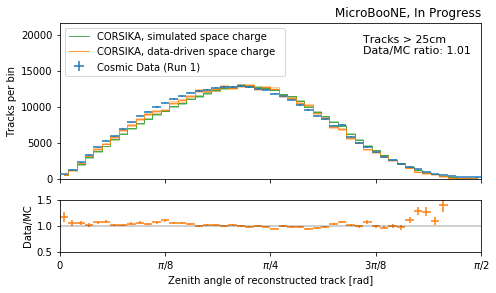

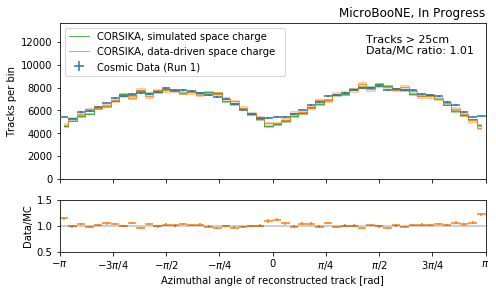

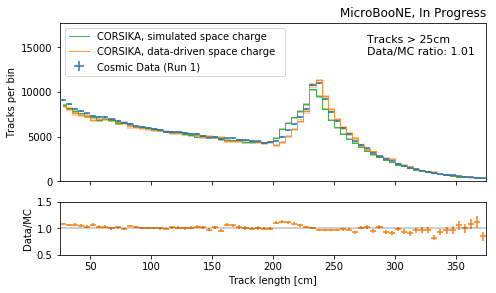

In [18]:
for s in list_plot:
    fig, ax = plt.subplots(nrows = 2, sharex=True, figsize=(7,4), gridspec_kw = {'height_ratios':[3, 1]})
    
    data_list = mc_pfp + [data_pfp]
    weights   = mc_scales + [1]
    data = [df.query(clean_query)[s["name"]] for df in data_list]
    edges, edges_mid, bins, err, max_y = helper.histHelper(s["bins"], s["x_min"], s["x_max"], data, weights=weights)
    
    ax[0].errorbar(edges_mid, bins[-1], yerr=err[-1], xerr=edges[:-1]-edges_mid, fmt='none', c='C0', 
                   zorder=3, label=data_lab)
    next(ax[0]._get_lines.prop_cycler)
    for i,(bins_i, err_i, lab_i, max_i, alpha_i, c_i) in enumerate(zip(bins,err,mc_labs, max_y, mc_alpha, mc_color)):
        if alpha_i>0:
            ax[0].step(edges_mid,bins_i,lw=1, label=lab_i, where='mid', alpha=alpha_i, c=c_i)
            ax[0].fill_between(edges_mid, (bins_i - err_i), (bins_i + err_i), alpha=0.3, step='mid', color=c_i)
        
    ax[0].set_ylim(0,max(max_y)*1.35)
    ax[0].set_ylabel("Tracks per bin")
    ax[0].set_xlim(s["x_min"],s["x_max"])
    ax[0].legend(loc = "upper left")
    if "x_labels" in s:
        ax[0].set_xticks(s["x_ticks"])
        ax[0].set_xticklabels(s["x_labels"] )
    
    ratio = bins[-1]/(bins[mc_def])
    ratio_err = np.sqrt(1/bins[-1]+1/ (bins[mc_def]/mc_scales[mc_def]))*ratio
    ax[1].errorbar(edges_mid, ratio, xerr= edges[1:]-edges_mid, yerr=ratio_err, fmt='none', color=mc_color[mc_def])

    ax[1].axhline(y=1,color="k",alpha=0.25)
    ax[1].set_xlabel(s["x_label"])
    ax[1].set_ylabel("Data/MC")
    ax[1].set_ylim(0.5,1.5)
    fig.tight_layout()
    text_x = s["x_min"]+(s["x_max"]-s["x_min"])*0.72
    ax[0].set_title(ub_tag, loc='right')
    ax[0].text(text_x, ax[0].get_ylim()[1]*0.8, 'Tracks > 25cm\n'+r"Data/MC ratio: {0:.2f}".format(ratio_25cm), fontsize=11)
    plt.savefig(outdir+s["name"]+"_25cm.pdf")


Length
38.0 	 36.16105 	 [-7.49995041 -2.19662476  1.31474781] 	 4.407349109649658
62.0 	 59.54476 	 [-11.58255081  -2.37969589   1.21071949] 	 6.396635150909423
88.0 	 84.26442 	 [-13.36932411  -2.39767838   1.241642  ] 	 7.305483055114744
112.0 	 108.89289 	 [-14.30055389  -2.34609222   1.23725891] 	 7.7689064025878904
138.0 	 133.98505 	 [-16.39632797  -2.32218933   1.28742523] 	 8.841876602172851
162.0 	 158.9985 	 [-17.28877716  -2.17498779   1.3175415 ] 	 9.303159332275388
188.0 	 184.45837 	 [-17.28945923  -2.11564636   1.275177  ] 	 9.282318115234375
212.0 	 212.4489 	 [-18.17947388  -0.90455627   0.49327087] 	 9.336372375488281
238.0 	 235.23543 	 [-15.30011139  -0.3449707    0.42937393] 	 7.86474266052246
262.0 	 259.6521 	 [-10.09769135  -0.26135254   0.74230881] 	 5.420000076293945
288.0 	 284.90585 	 [-9.55258789 -0.34213257  1.04203491] 	 5.297311401367186
312.0 	 309.43774 	 [-10.04878998  -0.47465515   1.17980957] 	 5.614299774169922
338.0 	 333.45834 	 [-11.42615356  

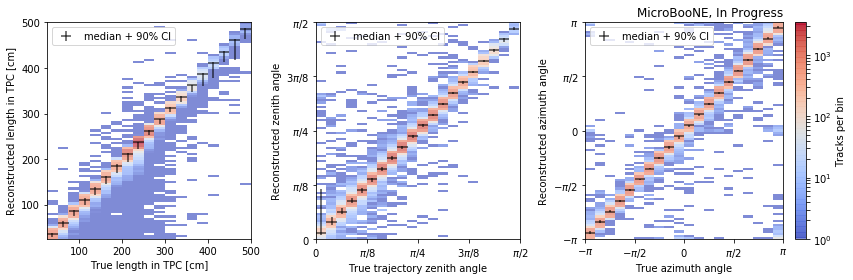

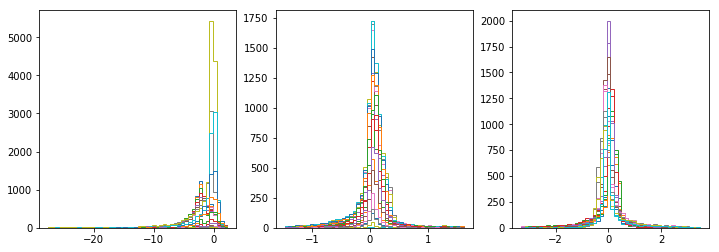

In [19]:
fig, ax = plt.subplots(ncols = 3, figsize=(12,4), gridspec_kw = {'width_ratios':[4,4,4.85]})
fig2, ax2 = plt.subplots(ncols = 3, figsize=(12,4))
n_x = 20
n_y = 101

print('\nLength')
y_max = 500
fld_mc, fld_reco = 'track_matched_length_sce', 'pfp_length_traj'
h,x_edges,y_edges,im = ax[0].hist2d(df_resolution[fld_mc], df_resolution[fld_reco], cmap='coolwarm', vmin=10, vmax=3400,
                                    bins=(n_x-1,n_y), alpha= 0.65, norm=colors.LogNorm(), range=((25,y_max),(25,y_max)))
ax[0].set_xlabel('True length in TPC [cm]')
ax[0].set_ylabel('Reconstructed length in TPC [cm]')
mids, mean, err = getResolution(df_resolution[fld_mc], df_resolution[fld_reco], x_edges, ax2[0])
ax[0].errorbar(mids, mean, xerr=(mids[0]-x_edges[0]), yerr=np.array(err).T, color='k', fmt='none', 
               label=r'median + 90% CI', alpha=0.7)
ax[0].legend(loc='upper left')


print('\nZenith')
fld_mc, fld_reco = 'mc_zenith_traj', 'pfp_zenith_traj'
h,x_edges,y_edges,im = ax[1].hist2d(df_resolution[fld_mc], df_resolution[fld_reco], cmap='coolwarm', vmin=1, vmax=3400,
                                    bins=(n_x,n_y), alpha= 0.65, norm=colors.LogNorm())
ax[1].set_xticks([0,np.pi/8,np.pi/4,3*np.pi/8,np.pi/2])
ax[1].set_xticklabels([r'$0$',r'$\pi/8$',r'$\pi/4$',r'$3\pi/8$',r'$\pi$/2'])
ax[1].set_yticks([0,np.pi/8,np.pi/4,3*np.pi/8,np.pi/2])
ax[1].set_yticklabels([r'$0$',r'$\pi/8$',r'$\pi/4$',r'$3\pi/8$',r'$\pi$/2'])
ax[1].set_xlabel('True trajectory zenith angle')
ax[1].set_ylabel('Reconstructed zenith angle')
ax[1].set_ylim(0,np.pi/2)
mids, mean, err = getResolution(df_resolution[fld_mc], df_resolution[fld_reco], x_edges, ax2[1], periodic=True)
ax[1].errorbar(mids, mean, xerr=(mids[0]-x_edges[0]), yerr=np.array(err).T, color='k', fmt='none', 
               label=r'median + 90% CI', alpha=0.7)
ax[1].legend(loc='upper left')

print('\nAzimuth')
fld_mc, fld_reco = 'mc_azimuth_traj', 'pfp_azimuth_traj'
h,x_edges,y_edges,im = ax[2].hist2d(df_resolution[fld_mc], df_resolution[fld_reco], cmap='coolwarm', vmin=1, vmax=3400,
                                    bins=(n_x,n_y), alpha= 0.65, norm=colors.LogNorm())
ax[2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
ax[2].set_xticklabels([r'$-\pi$',r'$-\pi/2$',r'$0$',r'$\pi/2$',r'$\pi$'])
ax[2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
ax[2].set_yticklabels([r'$-\pi$',r'$-\pi/2$',r'$0$',r'$\pi/2$',r'$\pi$'])
ax[2].set_xlabel('True azimuth angle')
ax[2].set_ylabel('Reconstructed azimuth angle')
ax[2].set_ylim(-np.pi,np.pi)
mids, mean, err = getResolution(df_resolution[fld_mc], df_resolution[fld_reco], x_edges, ax2[2], periodic=True)
ax[2].errorbar(mids, mean, xerr=(mids[0]-x_edges[0]), yerr=np.array(err).T, color='k', fmt='none', 
               label=r'median + 90% CI', alpha=0.7)
ax[2].legend(loc='upper left')
ax[2].set_title(ub_tag, loc='right')

clb = fig.colorbar(im, ax=ax[2])
clb.set_label('Tracks per bin', rotation=90)
fig.tight_layout()
fig.savefig(outdir+"resolution_25cm.pdf")
fig2.savefig(outdir+"resolution_shapes_25cm.pdf")

No handles with labels found to put in legend.
No handles with labels found to put in legend.


1193.1790268456357
2160.888324873088


No handles with labels found to put in legend.


1949.0


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


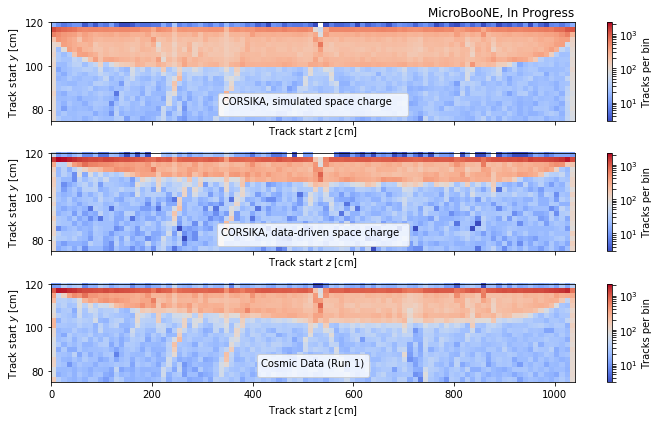

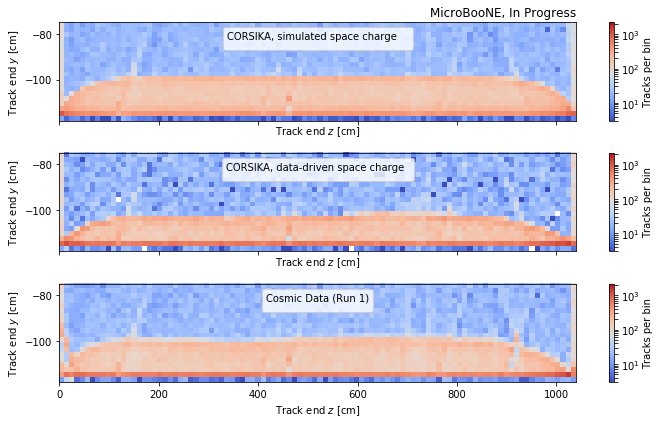

In [20]:
## 2D plot of the YZ boundary to look at the start point!
#mc_keys= ['sce', 'ddsce', 'nosce', 'cmc']
mc_index = slice(0, 2)
data_list = mc_pfp[mc_index] + [data_pfp]
weights   = mc_scales[mc_index] + [1]
labels    = mc_labs[mc_index] + [data_lab]
n_bins = (100,20)


fig, ax = plt.subplots(nrows = 3, sharex=True, sharey=True, figsize=(10,6))
yzrange = ((0,1040),(75,120))

for ax_i, df_i, scale_i, lab_i in zip(ax, data_list, weights, labels):
    w_i = [scale_i]*len(df_i)
    h,x_edges,y_edges,im = ax_i.hist2d(df_i['track_startz'], df_i['track_starty'], 
                                        weights=w_i, cmap='coolwarm', bins=n_bins, vmax=2200, vmin=3,
                                        range=yzrange, norm=colors.LogNorm())
    clb = fig.colorbar(im, ax=ax_i, label='Tracks per bin')
    ax_i.legend(loc='lower center', title=lab_i)
    ax_i.set_xlabel(r'Track start $z$ [cm]')
    ax_i.set_ylabel(r'Track start $y$ [cm]')
    print(np.amax(h))

ax[0].set_title(ub_tag, loc='right')
fig.tight_layout()
fig.savefig(outdir+"2d_track_start.pdf", bbox_inches="tight")

###########################

fig, ax = plt.subplots(nrows = 3, sharex=True, sharey=True, figsize=(10,6))
yzrange = ((0,1040),(-118,-75))

for ax_i, df_i, scale_i, lab_i in zip(ax, data_list, weights, labels):
    w_i = [scale_i]*len(df_i)
    h,x_edges,y_edges,im = ax_i.hist2d(df_i['track_endz'], df_i['track_endy'], 
                                        weights=w_i, cmap='coolwarm', bins=n_bins, vmax=2200, vmin=3,
                                        range=yzrange, norm=colors.LogNorm())
    clb = fig.colorbar(im, ax=ax_i, label='Tracks per bin')
    ax_i.legend(loc='upper center', title=lab_i)
    ax_i.set_xlabel(r'Track end $z$ [cm]')
    ax_i.set_ylabel(r'Track end $y$ [cm]')

ax[0].set_title(ub_tag, loc='right')
fig.tight_layout()
fig.savefig(outdir+"2d_track_end.pdf", bbox_inches="tight")

In [21]:
#purity, ratio in function of track length

ratio = []
purity = []
p_err = []
r_err = []

lengths = np.linspace(5, 175, 35)

for df, lab, scale in zip(mc_pfp, mc_labs, mc_scales):
    df_view = df.query(matched_muon_query)
    ratio_i = []
    purity_i = []
    p_err_i = []
    r_err_i = []
    print("\n"+lab)
    for l in lengths:
        df_view2 = df_view.query("pfp_length_traj>@l")
        df_view3 = df.query("(pfp_length_traj>@l)")
        broken_pure_bool = ~df_view2.duplicated(subset=['track_matched_time', 'track_matched_energy'], keep=False)
        denom =len(df_view3)
        r = len(data_pfp.query("pfp_length_traj>@l"))/denom/scale
        print("length cut: {0:.2f} \t purtiy: {1:.2f}% \t data/MC: {2:.3f}".format(l, sum(broken_pure_bool)/denom*100, r))
        purity_i.append(sum(broken_pure_bool)/denom)
        ratio_i.append(r)
    ratio.append(ratio_i)
    purity.append(purity_i)


CORSIKA, simulated space charge    
length cut: 5.00 	 purtiy: 85.42% 	 data/MC: 1.051
length cut: 10.00 	 purtiy: 92.70% 	 data/MC: 1.035
length cut: 15.00 	 purtiy: 95.63% 	 data/MC: 1.028
length cut: 20.00 	 purtiy: 97.02% 	 data/MC: 1.024
length cut: 25.00 	 purtiy: 97.71% 	 data/MC: 1.021
length cut: 30.00 	 purtiy: 98.11% 	 data/MC: 1.020
length cut: 35.00 	 purtiy: 98.40% 	 data/MC: 1.019
length cut: 40.00 	 purtiy: 98.61% 	 data/MC: 1.018
length cut: 45.00 	 purtiy: 98.76% 	 data/MC: 1.018
length cut: 50.00 	 purtiy: 98.90% 	 data/MC: 1.018
length cut: 55.00 	 purtiy: 99.01% 	 data/MC: 1.017
length cut: 60.00 	 purtiy: 99.11% 	 data/MC: 1.017
length cut: 65.00 	 purtiy: 99.20% 	 data/MC: 1.016
length cut: 70.00 	 purtiy: 99.29% 	 data/MC: 1.016
length cut: 75.00 	 purtiy: 99.35% 	 data/MC: 1.016
length cut: 80.00 	 purtiy: 99.40% 	 data/MC: 1.017
length cut: 85.00 	 purtiy: 99.45% 	 data/MC: 1.017
length cut: 90.00 	 purtiy: 99.49% 	 data/MC: 1.017
length cut: 95.00 	 purtiy: 

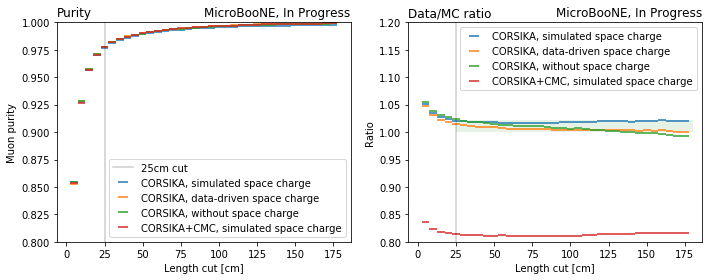

In [22]:
fig, ax = plt.subplots(ncols = 2, sharex=True, sharey=False, figsize=(10,4))

for p,r,lab in zip(purity, ratio, mc_labs):
    ax[0].errorbar(lengths, p, xerr=(lengths[1]-lengths[0])/2, fmt="none", label=lab) 
    ax[1].errorbar(lengths, r, xerr=(lengths[1]-lengths[0])/2, fmt="none", label=lab) 
    
ax[0].axvline(x=25, alpha=0.2, color='k', label="25cm cut")
ax[0].set_ylim(0.8,1)
ax[0].set_ylabel("Muon purity")
ax[0].set_title("Purity", loc="left")
ax[0].set_title(ub_tag, loc="right")
ax[0].set_xlabel("Length cut [cm]")
ax[1].set_ylim(0.8,1.2)
ax[1].set_title("Data/MC ratio", loc="left")
ax[1].set_ylabel("Ratio")
ax[1].set_title(ub_tag, loc="right")
ax[1].set_xlabel("Length cut [cm]")
ax[1].legend()
ax[0].legend(loc='lower right')

ax[1].axvline(x=25, alpha=0.2, color='k', label="none")

rect = patches.Rectangle((25,1),155,0.022,facecolor='green', alpha=0.1)
ax[1].add_patch(rect)


fig.tight_layout()
fig.savefig(outdir+"syst_length.pdf", bbox_inches="tight")

In [23]:
# calculate muon flux:
start, start_err = 127.7, 0.2
tpc, tpc_err = 111.6, 0.3
ratio, ratio_err = ratio_25cm, r_err
ratio, ratio_err = 0.9626, 0.0061

err = np.sqrt( (start_err/start)**2 + (ratio_err/ratio)**2 ) * (ratio*start)
print("Extrtapolated rate at 18m: {0:.1f}+-{1:.1f}".format(ratio*start, err))
err = np.sqrt( (tpc_err/tpc)**2 + (ratio_err/ratio)**2 ) * (ratio*tpc)
print("Extrtapolated rate at TPC: {0:.1f}+-{1:.1f}".format(ratio*tpc, err))

Extrtapolated rate at 18m: 122.9+-0.8
Extrtapolated rate at TPC: 107.4+-0.7
